In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as pl

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA

In [2]:
def visualize_data(total_data, train_size, test_size):
    ''' Visualization of total spam data
    :param total_data: Train and test data
    :param train_size: Size of train set
    :param test_size: Size of test set
    :return:
    '''
    pca = PCA(n_components=2)
    projection = pca.fit_transform(total_data)

    fig = pl.figure(figsize=(8, 8))

    pl.rcParams['legend.fontsize'] = 10
    pl.plot(projection[0:train_size, 0], projection[0:train_size, 1],
            'o', markersize=2, color='blue', alpha=0.5, label='Train')
    pl.plot(projection[train_size:train_size+test_size, 0], projection[train_size:train_size+test_size, 1],
            'o', markersize=2, color='red', alpha=0.5, label='Test')
    pl.title('Spam data')
    pl.show()


In [3]:
def classification_report(y_true, y_pred, results):
    ''' Computes clasification metrics

    :param y_true - original class label
    :param y_pred - predicted class label
    :return presicion, recall for each class; micro_f1 measure, macro_f1 measure
    '''
    last_line_heading = 'avg / total'
    final_line_heading = 'final score'

    labels = unique_labels(y_true, y_pred)
#     print(f'labels = {labels}')

    width = len(last_line_heading)
    target_names = ['{0}'.format(l) for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 9s' for _ in headers])
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None)

    f1_macro = 0
    precision_macro = 0
    recall_macro = 0

    for i, label in enumerate(labels):
        values = [target_names[i]]
        f1_macro += f1[i]
        precision_macro += p[i]
        recall_macro += r[i]
        for v in (p[i], r[i], f1[i]):
            values += ["{0:0.5f}".format(v)]
        values += ["{0}".format(s[i])]
        report += fmt % tuple(values)

    report += '\n'

    # compute averages
    values = [last_line_heading]
    for v in (np.average(p, weights=s),
              np.average(r, weights=s),
              np.average(f1, weights=s)):
        values += ["{0:0.5f}".format(v)]
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)
    
    

    values = [final_line_heading]
    for v in (precision_macro, recall_macro, f1_macro):
        values += ["{0:0.5f}".format(v / labels.size)]
    results.append(v / labels.size)
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)

    return report


In [4]:
def parse_args(a):
    parser = argparse.ArgumentParser(description='Random Forest Tutorial')
    parser.add_argument("-tr", "--train", action="store", type=str, help="Train file name")
    parser.add_argument("-te", "--test", action="store", type=str, help="Test file name")
    parser.add_argument("-t", "--trees", action="store", type=int, help="Number of trees in random forest", default=10)
    parser.add_argument("-fp", "--features_percent", action="store", type=float, help="Percent of features in each tree", default=0.9)
    return parser.parse_args(a)

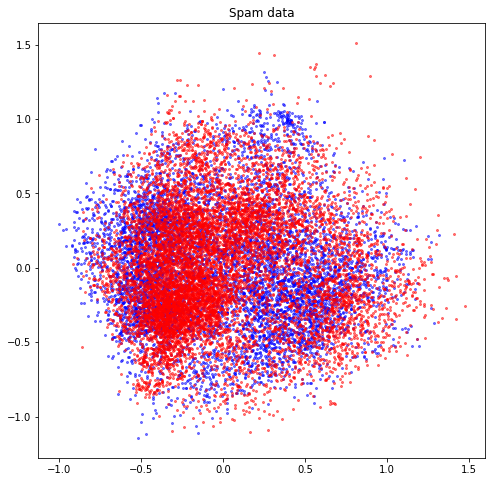

             precision    recall  f1-score   support

        0.0    0.56157   0.86818   0.68199      2033
        1.0    0.96123   0.82824   0.88980      8023

avg / total    0.88043   0.83632   0.84779     10056
final score    0.76140   0.84821   0.78590     10056



In [5]:

args = parse_args(['-tr', 'spam.train.txt', '-te', 'spam.test.txt'])

train_data = np.loadtxt(args.train)
test_data  = np.loadtxt(args.test)

total_data = np.concatenate(([train_data, test_data]), axis=0)

visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

number_of_features = len(train_data[0, :])

use_features_in_tree = (int)(args.features_percent * number_of_features)

# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = args.trees, max_features=use_features_in_tree, n_jobs=-1)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(train_data[0::, 1::], train_data[0::, 0])

# Take the same decision trees and run it on the test data
prediction = forest.predict(test_data[0::, 1::])
metrics = []
print(classification_report(test_data[0::, 0], prediction, metrics))

In [6]:
metrics

[0.7858951412683814]

#### Написать функцию, подбирающую параметры числа деревьев и процента признаков в деревьях. Построить график.

In [7]:
from matplotlib import pyplot as plt
from collections import defaultdict

In [8]:
%%time 
all_metrics = defaultdict(list)
for features_percent in (0.01, 0.1, 0.3, 0.5, 0.7, 0.99):
    for trees in (10, 100, 500, 1000, 10000):
        curr_metrics = []
        use_features_in_tree = (int)(features_percent * number_of_features)
        forest = RandomForestClassifier(n_estimators = trees, max_features=use_features_in_tree, n_jobs=-1)
        forest = forest.fit(train_data[0::, 1::], train_data[0::, 0])
        prediction = forest.predict(test_data[0::, 1::])

        print(f'features_percent={features_percent}, trees={trees}')
        print(classification_report(test_data[0::, 0], prediction, curr_metrics))
        all_metrics[features_percent].append(curr_metrics)
        all_metrics[trees].append(curr_metrics)

features_percent=0.01, trees=10
             precision    recall  f1-score   support

        0.0    0.34137   0.96803   0.50474      2033
        1.0    0.98485   0.52674   0.68637      8023

avg / total    0.85476   0.61595   0.64965     10056
final score    0.66311   0.74738   0.59556     10056

features_percent=0.01, trees=100
             precision    recall  f1-score   support

        0.0    0.74088   0.94934   0.83226      2033
        1.0    0.98618   0.91587   0.94972      8023

avg / total    0.93659   0.92263   0.92597     10056
final score    0.86353   0.93260   0.89099     10056

features_percent=0.01, trees=500
             precision    recall  f1-score   support

        0.0    0.81806   0.93556   0.87288      2033
        1.0    0.98306   0.94728   0.96483      8023

avg / total    0.94970   0.94491   0.94624     10056
final score    0.90056   0.94142   0.91886     10056

features_percent=0.01, trees=1000
             precision    recall  f1-score   support

        0.

features_percent=0.99, trees=1000
             precision    recall  f1-score   support

        0.0    0.71736   0.85145   0.77868      2033
        1.0    0.96049   0.91499   0.93719      8023

avg / total    0.91134   0.90215   0.90514     10056
final score    0.83893   0.88322   0.85793     10056

features_percent=0.99, trees=10000
             precision    recall  f1-score   support

        0.0    0.71306   0.85932   0.77939      2033
        1.0    0.96240   0.91238   0.93672      8023

avg / total    0.91199   0.90165   0.90491     10056
final score    0.83773   0.88585   0.85805     10056

CPU times: user 5h 11min, sys: 31.3 s, total: 5h 11min 31s
Wall time: 40min 21s


In [22]:
# all_metrics

In [23]:
# saved in order not to recalculate the results
all_metrics = defaultdict(list,
            {0.01: [[0.5955590200391625],
              [0.8909886984820007],
              [0.9188558972588122],
              [0.9233582770823268],
              [0.9227773713318252]],
             10: [[0.5955590200391625],
              [0.8087877821843682],
              [0.8265088725558987],
              [0.8088240046338658],
              [0.8120667112015825],
              [0.833339947777848]],
             100: [[0.8909886984820007],
              [0.9139393931761266],
              [0.8999955463547946],
              [0.9046175540644947],
              [0.9054486668574276],
              [0.8580474905977584]],
             500: [[0.9188558972588122],
              [0.9200479695790563],
              [0.9184376780910123],
              [0.9123239897118445],
              [0.9068226074985734],
              [0.856090939423299]],
             1000: [[0.9233582770823268],
              [0.9180698526016136],
              [0.91701557367871],
              [0.9127824890730023],
              [0.9088402389235837],
              [0.8579331397166872]],
             10000: [[0.9227773713318252],
              [0.9232620995037493],
              [0.9165983191582956],
              [0.9150946586529548],
              [0.9085911563417373],
              [0.858054500885159]],
             0.1: [[0.8087877821843682],
              [0.9139393931761266],
              [0.9200479695790563],
              [0.9180698526016136],
              [0.9232620995037493]],
             0.3: [[0.8265088725558987],
              [0.8999955463547946],
              [0.9184376780910123],
              [0.91701557367871],
              [0.9165983191582956]],
             0.5: [[0.8088240046338658],
              [0.9046175540644947],
              [0.9123239897118445],
              [0.9127824890730023],
              [0.9150946586529548]],
             0.7: [[0.8120667112015825],
              [0.9054486668574276],
              [0.9068226074985734],
              [0.9088402389235837],
              [0.9085911563417373]],
             0.99: [[0.833339947777848],
              [0.8580474905977584],
              [0.856090939423299],
              [0.8579331397166872],
              [0.858054500885159]]})

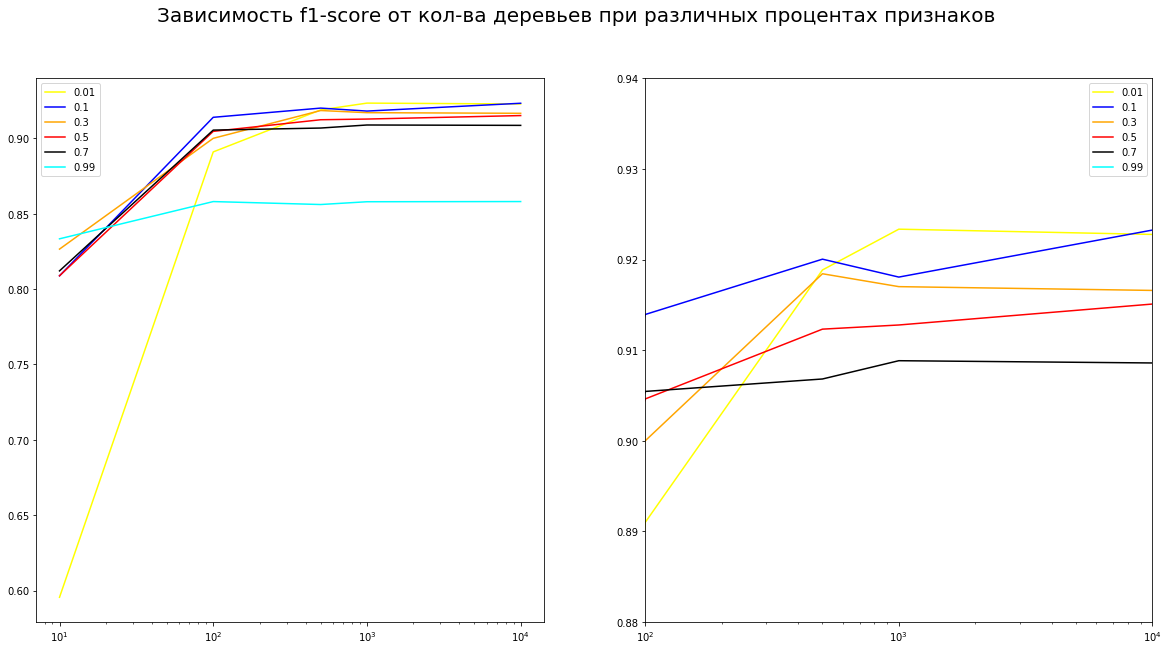

In [45]:
fig = plt.figure(1, figsize=(20,10))
fig.suptitle('Зависимость f1-score от кол-ва деревьев при различных процентах признаков', fontsize=20)

plt.subplot(121)
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.01]).flatten(), color='yellow', label='0.01')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.1]).flatten(), color='blue', label='0.1')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.3]).flatten(), color='orange', label='0.3')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.5]).flatten(), color='red', label='0.5')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.7]).flatten(), color='black', label='0.7')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.99]).flatten(), color='cyan', label='0.99')
plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.01]).flatten(), color='yellow', label='0.01')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.1]).flatten(), color='blue', label='0.1')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.3]).flatten(), color='orange', label='0.3')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.5]).flatten(), color='red', label='0.5')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.7]).flatten(), color='black', label='0.7')
plt.plot([10, 100, 500, 1000, 10000], np.asarray(all_metrics[0.99]).flatten(), color='cyan', label='0.99')
plt.xscale('log')
plt.legend()
plt.xlim(100,10000)
plt.ylim(0.88,0.94)


plt.show()

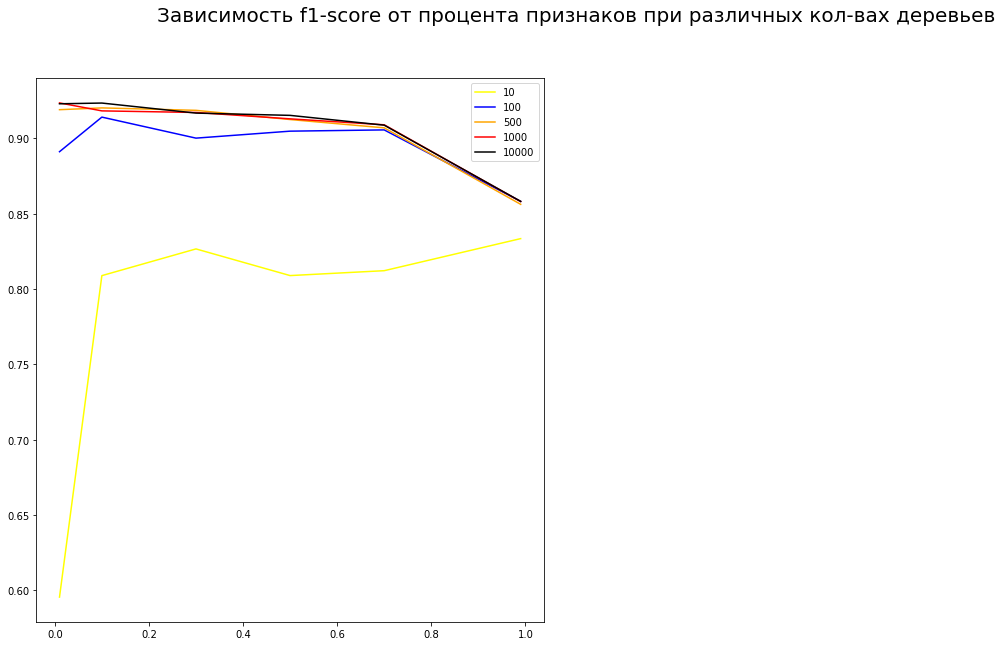

In [54]:
fig = plt.figure(1, figsize=(20,10))
fig.suptitle('Зависимость f1-score от процента признаков при различных кол-вах деревьев', fontsize=20)

plt.subplot(121)
plt.plot([0.01, 0.1, 0.3, 0.5, 0.7, 0.99], np.asarray(all_metrics[10]).flatten(), color='yellow', label=10)
plt.plot([0.01, 0.1, 0.3, 0.5, 0.7, 0.99], np.asarray(all_metrics[100]).flatten(), color='blue', label=100)
plt.plot([0.01, 0.1, 0.3, 0.5, 0.7, 0.99], np.asarray(all_metrics[500]).flatten(), color='orange', label=500)
plt.plot([0.01, 0.1, 0.3, 0.5, 0.7, 0.99], np.asarray(all_metrics[1000]).flatten(), color='red', label=1000)
plt.plot([0.01, 0.1, 0.3, 0.5, 0.7, 0.99], np.asarray(all_metrics[10000]).flatten(), color='black', label=10000)
# plt.xscale('log')
plt.legend()

plt.show()

>По графикам видно, что качество растет от кол-ва деревьев  
Что касается зависимости от кол-ва признаков - видно, что на малом числе деревьев лучше большой процент фич, но модель с наименьшим процентов признаков = 0.01 обгоняет на 100-1000 деверьях и  на 1000 деревьев дает лучший скор. 
Это объясняется тем, что лучшая итоговая модель достигается при ассамблировании наибольшего числа наиболее различных друг от друга моделей

#### Почему качество классификации для класса spam выше, чем для класса notspam?

In [51]:
y = train_data[:, 0]
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0., 1.]), array([2970, 4123]))

In [52]:
y = test_data[:, 0]
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0., 1.]), array([2033, 8023]))

>В данных сильный дисбаланс класса.